# Описание проекта, загрузка данных

В данном проекта будут исследоваться исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы c 1980 по 2016 год. Необходимо выявить влияющие на успешность играы факторы для планирования рекламных кампаний на 2017 год. 
Сначала необходимо подготовить данные к анализу, найти в них ошибки, пропуски и дубликаты. Далее необходимо проанализировать изменения продаж по платформам, выявить актуальный период, на основании которого будут строиться прогнозы. Посмотреть, оказывают ли влияние на продажи отзывы пользователей и критиков, проанализировать распределение игр по жанрам, какие являются наиболее популярными.
Далее составить портрет пользователей регионов NA, EU, JP, проанализировать продажи по платформам, по жанрам и в зависимости от рейтинга ESRB. И в конце проверить гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые и средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Подготовка данных

In [3]:
games = games.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release',\
'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 'Other_sales':'other_sales',\
'Critic_Score':'critic_score', 'User_Score':'user_score', 'Rating':'rating'})
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Удаляем строчки с пропусками в столбце с годом релиза, т.к. этих данных достаточно мало (всего 269 из 16713, что равно меньше, чем 2%)

In [4]:
games = games.dropna(subset=['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype('int')

In [5]:
games.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         6607
rating             6678
dtype: int64

In [6]:
games = games.dropna(subset=['name'])

Явных дубликатов анализ не выявил

In [8]:
games.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
16710    False
16711    False
16712    False
16713    False
16714    False
Length: 16444, dtype: bool

In [11]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'].isna().sum()

8981

In [12]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce', downcast='float')
games['user_score'] = games['user_score'].astype('float64')

In [14]:
print(games['critic_score'].unique())

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]


Заполним сначала пропуски в столбце critic_score нулями, чтобы было возможно изменить тип данных столбца, а реальных оценок критиков мы не знаем, и удалять пропуски нельзя, т.к. их достаточно много и они могут повлиять на дальнейшее исследование, а так можно будет просто применить фильтрацию 

In [15]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['critic_score'] = games['critic_score'].astype('int')

games['rating'] = games['rating'].fillna(-1)

In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


Заменяем значения tbd в столбце с оценками пользователей на nan, потому что tbd означает, что оценка уточняется, то есть ее пока нет

Как показалось из изучения данных, пропуски в столбцах с оценками критиков и пользователей, а также столбце рейтинга, в первую очередь встречаются у игр, выпущенных в конце 20-го века и в начале 21-го (в первом десятилетии), то есть данные по этим играм могли быть просто необновлены или утеряны 

In [17]:
games['region_sales'] = games[['na_sales', 'jp_sales', 'eu_sales', 'other_sales']].sum(axis=1)

In [18]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,region_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,NaN,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,NaN,-1,31.38


## Исследовательский анализ данных

В целом, если учитывать, какое кол-во игр стало выпускаться после 2002 года, можно предположить, что года, в которые выпускалось меньше хотя бы 100 игр, то есть до 1994 года, можно не учитывать, так как это кажется слишком незначительным количеством 

<AxesSubplot:xlabel='year_of_release'>

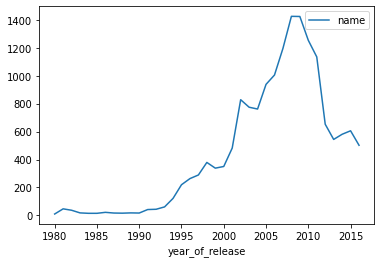

In [20]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count').plot()

In [21]:
games = games.loc[games['year_of_release'] >= 1994]

In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16079 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16079 non-null  object 
 1   platform         16079 non-null  object 
 2   year_of_release  16079 non-null  int64  
 3   genre            16079 non-null  object 
 4   na_sales         16079 non-null  float64
 5   eu_sales         16079 non-null  float64
 6   jp_sales         16079 non-null  float64
 7   other_sales      16079 non-null  float64
 8   critic_score     16079 non-null  int64  
 9   user_score       7460 non-null   float64
 10  rating           16079 non-null  object 
 11  region_sales     16079 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


Смотрим, какие платформы имели наибольшие продажи суммарно по регионам. На основании сводоной таблицы были выбран топ 6 платформ

<AxesSubplot:xlabel='platform'>

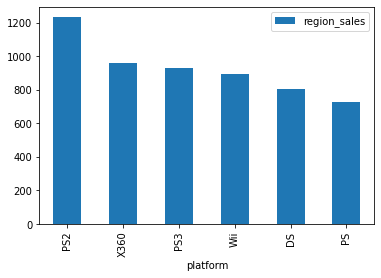

In [23]:
platform_sales = games.pivot_table(index='platform', values='region_sales', aggfunc='sum')
platform_sales = platform_sales.sort_values(by='region_sales', ascending=False)
top6_platforms = platform_sales.head(6)
top6_platforms.plot(kind='bar')

In [24]:
games['region_sales'] = pd.to_numeric(games['region_sales'], errors='coerce', downcast='float')

In [25]:
platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
print(platforms)

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']


Можно заметить, что некоторые платформы как бы сменяли друг друга, так, когда прожади PS падали, продажи PS2 начинали растит, аналогично происходило и с PS2 и DS. В 2005 года начали расти продажи у нескольких платформ: DS, Wii, X360 и PS3. Примерно с 2010 года продажи этих платформ стали падать.

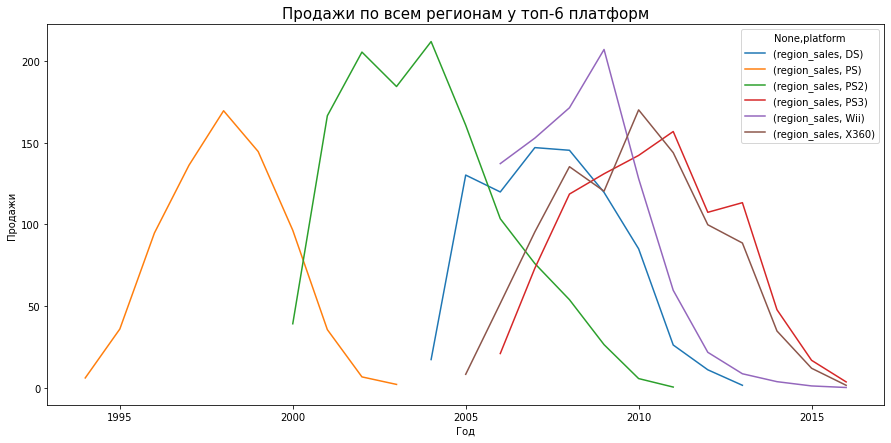

In [26]:
games_top6 = games.query('platform in @platforms').pivot_table(index=['year_of_release'], columns=['platform'], values=['region_sales'], aggfunc='sum')
games_top6.plot(figsize=(15, 7))
plt.title('Продажи по всем регионам у топ-6 платформ', fontsize=(15))
plt.xlabel('Год', fontsize=(10))
plt.ylabel('Продажи', fontsize=(10))
plt.show()

Предположим, что актуальным будет период с 2014 года.

In [27]:
games_2014 = games.query('year_of_release > 2013')


In [28]:
top_platforms_2014 = games_2014['platform'].value_counts() 
top_platforms_2014 = pd.to_numeric(top_platforms_2014, errors='coerce', downcast='float')
platforms_2014 = games_2014['platform'].unique()
platforms_2014

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

Продажи PSP приблизились к 0 к 2015 году. В целом, продажи всех платформ сократились к 2016 году. 
В начале актуального периода по продажам лидировали PS4, продажи были примерно 80 млн копий, и XOne, продажи были примерно 50 млн копий. А с 2015 года данные платформы достаточно упали в продажах, примерно на 10 млн копий к 2016 году.

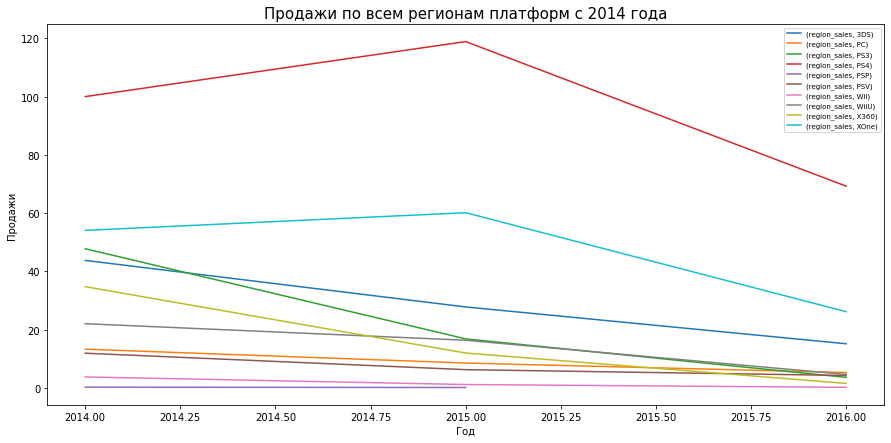

In [29]:
top_games_2014 = games_2014.query('platform in @platforms_2014').pivot_table(index=['year_of_release'], columns=['platform'], values=['region_sales'], aggfunc='sum')
top_games_2014.plot(figsize=(15, 7))
plt.title('Продажи по всем регионам платформ c 2014 года', fontsize=(15))
plt.xlabel('Год', fontsize=(10))
plt.ylabel('Продажи', fontsize=(10))
plt.legend(fontsize=(7))

plt.show()

In [30]:
five_platforms_2014 = games_2014.pivot_table(index='platform', values='region_sales', aggfunc='sum')
five_platforms_2014 = five_platforms_2014.sort_values(by='region_sales', ascending=False).head(5)
five_platforms_2014
platforms_2014 = ['PS4', 'XOne', '3DS', 'PS3', 'X360']

In [31]:
top_5_platforms_2014 = games_2014.query('platform in @platforms_2014')
top_5_platforms_2014

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,region_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,NaN,-1,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,NaN,-1,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,NaN,-1,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0.00,0.00,0.00,-1,NaN,M,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,-1,NaN,-1,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,-1,NaN,-1,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,NaN,-1,0.01


Text(0, 0.5, 'Продажи')

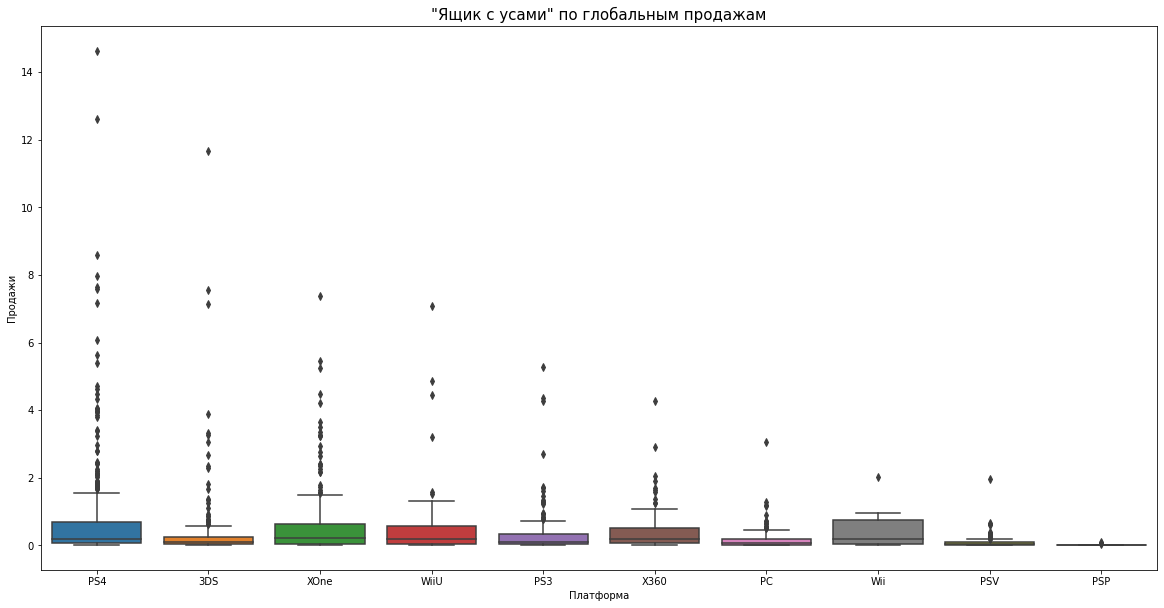

In [32]:
plt.figure(figsize=(20,10))
sns.boxplot(data=games_2014, x='platform', y='region_sales')
plt.title('"Ящик с усами" по глобальным продажам', fontsize=(15))
plt.xlabel('Платформа', fontsize=(10))
plt.ylabel('Продажи', fontsize=(10))


(0.0, 0.8)

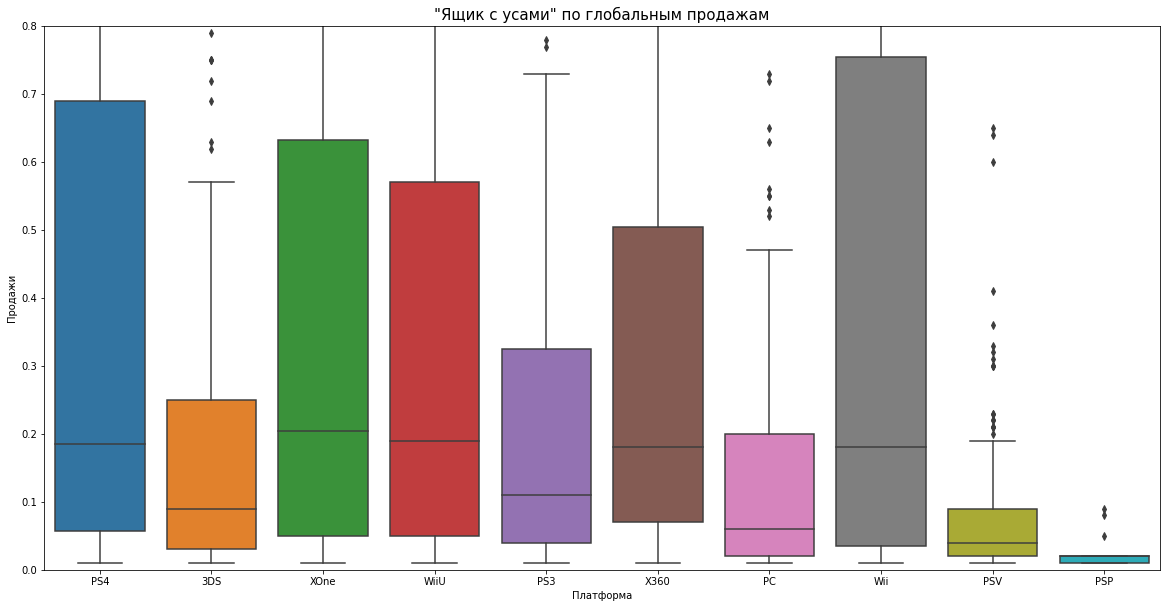

In [33]:
plt.figure(figsize=(20,10))
sns.boxplot(data=games_2014, x='platform', y='region_sales')
plt.title('"Ящик с усами" по глобальным продажам', fontsize=(15))
plt.xlabel('Платформа', fontsize=(10))
plt.ylabel('Продажи', fontsize=(10))
plt.ylim([0, 0.8])

Данные о продажах не симметричны, также в них имеются выбросы. Медианной значение у платформ PS4, XOne, WiiU, X360, Wii примерно равно 200 тысячам копий, для остальных оно находится примерно на уровне 100 тыс копий. Верхний предел продаж наивысший у PS4 и Wii. У PS4 и X360 самый большой разрыв между нижним квартилем и нижней границей. Большинство значений располагаются над медианой. Распределение смещено вправо.

Сложно говорить о связи отзывов критиков и продажами игр для платформы PS4, т.к. достаточно игр с оценками выше 60 имеют продажи приближающиеся к нулю. 


0.4026614122246821

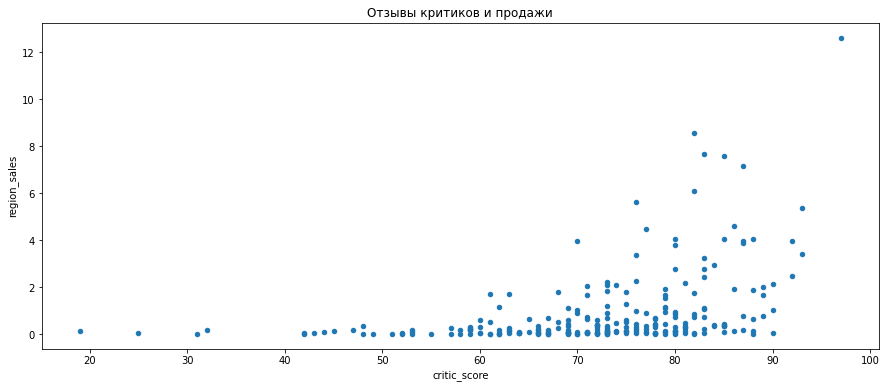

In [34]:
games_2014_ps4 = games_2014.query('platform == "PS4"')
games_2014_fltd = games_2014_ps4.query('critic_score > 0')
games_2014_fltd.plot(figsize=(15,6), kind='scatter', x='critic_score', y='region_sales')
plt.title('Отзывы критиков и продажи')

games_2014_fltd.query('platform == "PS4"')['critic_score'].corr(games_2014_fltd.query('platform == "PS4"')['region_sales'])

-0.04013158815891951

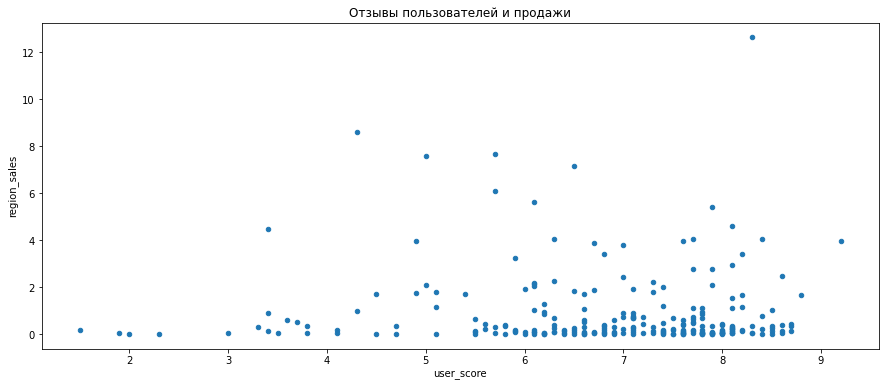

In [35]:
games_2014.query('platform == "PS4"').plot(figsize=(15,6), kind='scatter', x='user_score', y='region_sales')
plt.title('Отзывы пользователей и продажи')

games_2014.query('platform == "PS4"')['user_score'].corr(games_2014.query('platform == "PS4"')['region_sales'])

-0.013070307681861373

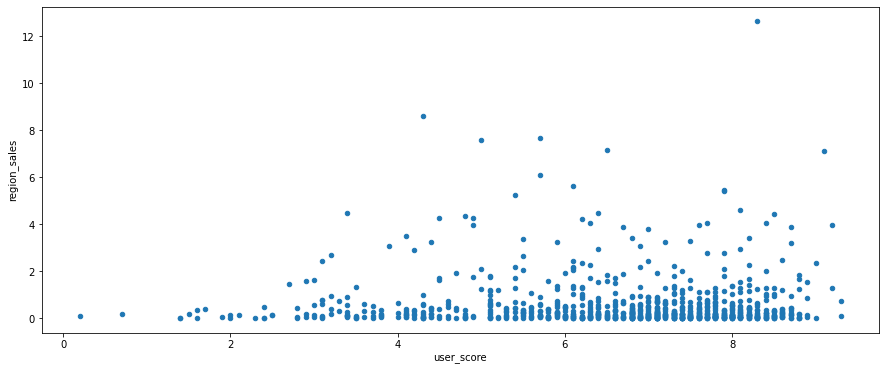

In [36]:
games_2014.plot(figsize=(15,6), kind='scatter', x='user_score', y='region_sales')
games_2014['user_score'].corr(games_2014['region_sales'])

Корреляция крайне слабая, и она отрицательная, то есть чем ниже оценка пользователей, тем выше будут продажи. Но по графику все-таки заметно, что с ростом оценок пользователей продажи игр растут.

<AxesSubplot:xlabel='critic_score', ylabel='region_sales'>

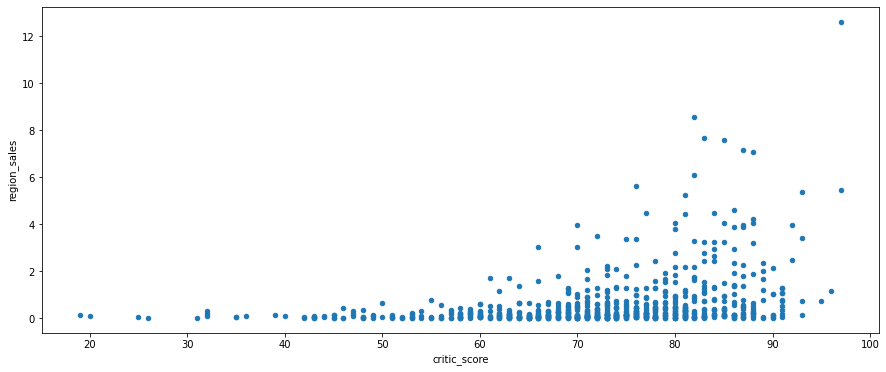

In [37]:
games_2014_all_platforms = games_2014.query('critic_score > 0')
games_2014_all_platforms.query('platform == platform')['critic_score'].corr(games_2014_all_platforms.query('platform == platform')['region_sales'])
games_2014_all_platforms.plot(figsize=(15,6), kind='scatter', x='critic_score', y='region_sales')


Если посмотреть на распределение продаж относительно оценок критиков или оценок пользователей по всем платформам, то прослеживается тот же вывод, что и отдельно для PS4.

,region_sales,critic_score,user_score
region_sales,1.000000,0.428677,-0.091734
critic_score,0.428677,1.000000,0.440977
user_score,-0.091734,0.440977,1.000000


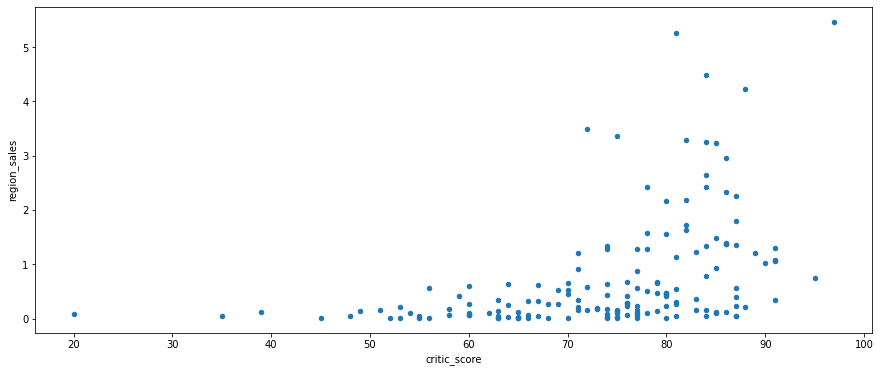

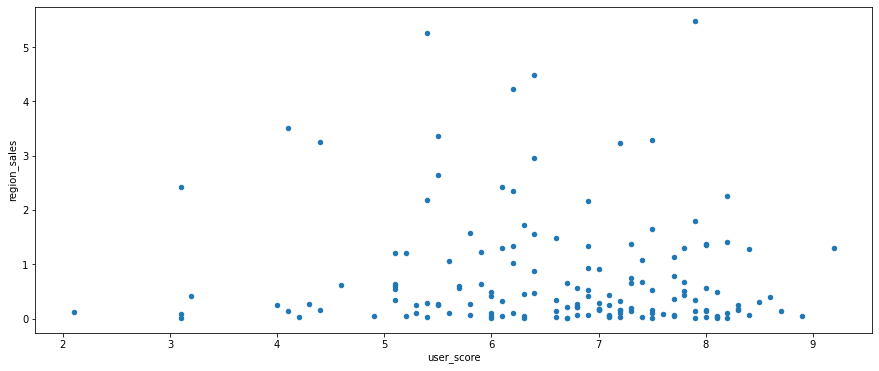

In [38]:
def score(platform):
    temp = games_2014_all_platforms[games_2014_all_platforms['platform'] == platform]
    temp.index = temp.index.astype('int')
    temp[['region_sales', 'critic_score', 'user_score']].corr()
    temp.plot(figsize=(15,6), kind='scatter', x='critic_score', y='region_sales')
    temp.plot(figsize=(15,6), kind='scatter', x='user_score', y='region_sales')
    display(temp[['region_sales', 'critic_score', 'user_score']].corr())

score('XOne')

,region_sales,critic_score,user_score
region_sales,1.000000,0.314117,0.279850
critic_score,0.314117,1.000000,0.862485
user_score,0.279850,0.862485,1.000000


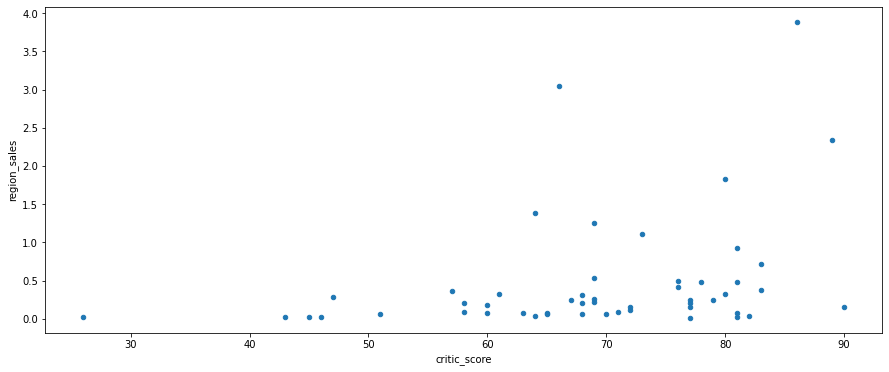

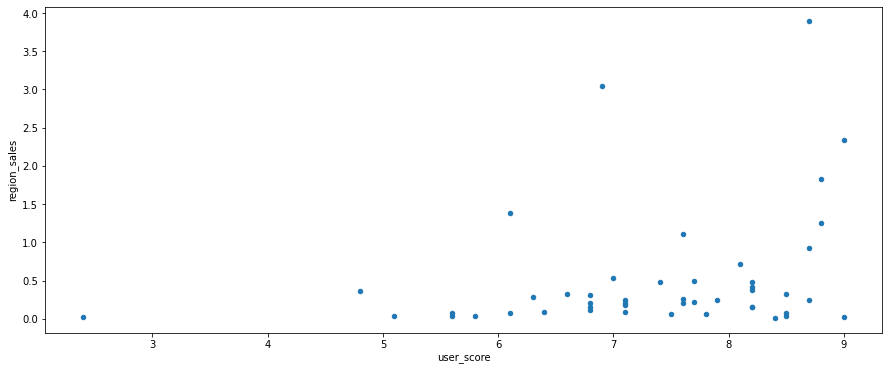

In [39]:
score('3DS')

,region_sales,critic_score,user_score
region_sales,1.000000,0.525723,0.336514
critic_score,0.525723,1.000000,0.625309
user_score,0.336514,0.625309,1.000000


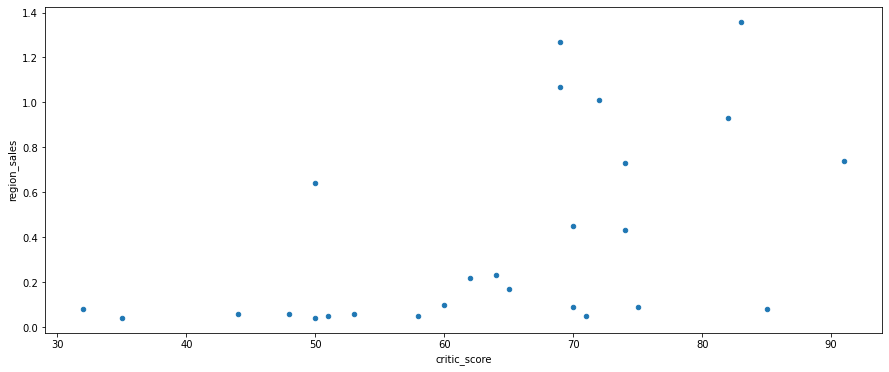

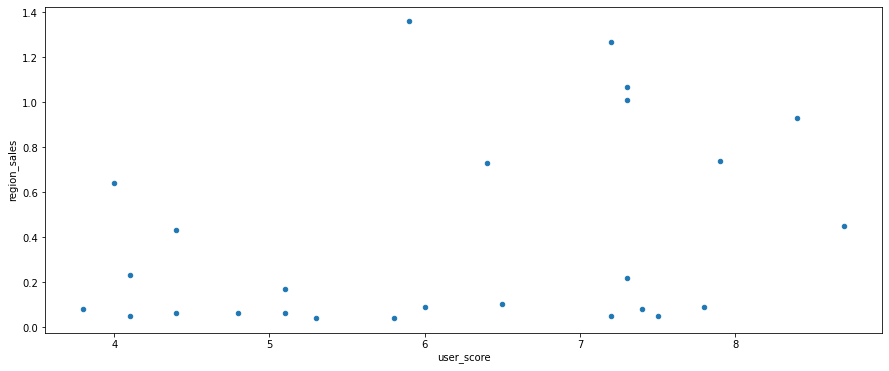

In [40]:
score('X360')

Корреляция для других платформ, которые имели одни из самых высоких показателей продаж по регионам, достаточно слабые. Тем не менее у платформ, кроме X360, заметна та же тенденция, что у PS4, опираясь на графики можно сделать вывод, что все-таки продажи связаны с оценками, так как заметно, что с ростом оценки, увеличивается и кол-во проданных копий.
У платформы X360 между оценками пользователей и критиков и продажами не прослеживается взаимосвязи.


<AxesSubplot:xlabel='genre'>

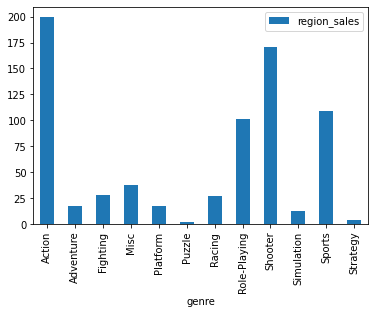

In [41]:
games_2014.pivot_table(index='genre', values='region_sales', aggfunc='sum').plot(kind='bar')

Среди продаж с большим отрывом лидирует жанры "action" и "shooter", самыми менее продаваемыми являются "strategy" и "puzzle"

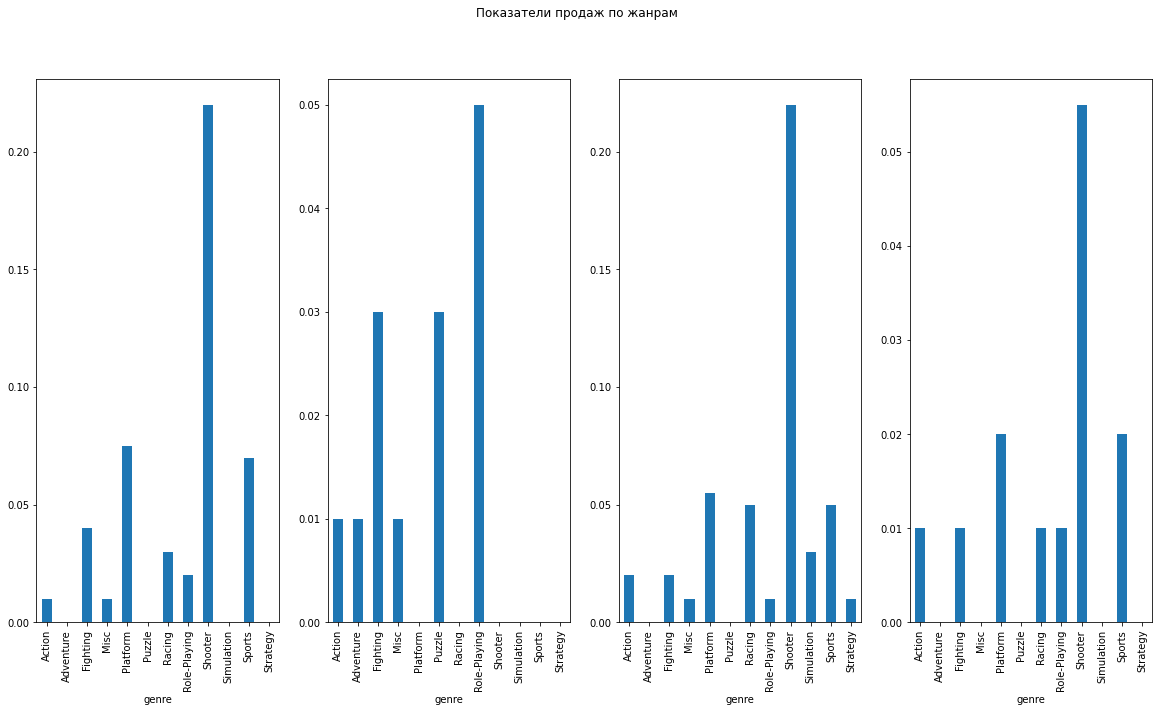

In [42]:
def genre_stat (game_genre, ax): 
    games_2014.groupby('genre')[game_genre].median().plot(ax=ax, kind='bar')
game_genre = ['na_sales', 'jp_sales', 'eu_sales', 'other_sales']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
fig.suptitle('Показатели продаж по жанрам')
for i in range(len(ax)):    
    genre_stat(game_genre[i], ax[i])

Если рассматривать продажи по жанрам отдельно для каждого региона, то, во-первых, можно отметить, что по продаже некоторых жанров в регионах отсутсвуют данные. 
В Японии наиболее популярным жанром является "role-playing", во всех остальных "shooter"

## Портреты пользователей каждого региона

In [43]:
na_platforms = games_2014.pivot_table(index='platform', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)
na_platforms

,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05
7,WiiU,19.36
1,PC,7.23
5,PSV,2.52
6,Wii,2.08
4,PSP,0.00


Text(0.5, 1.0, 'Japan')

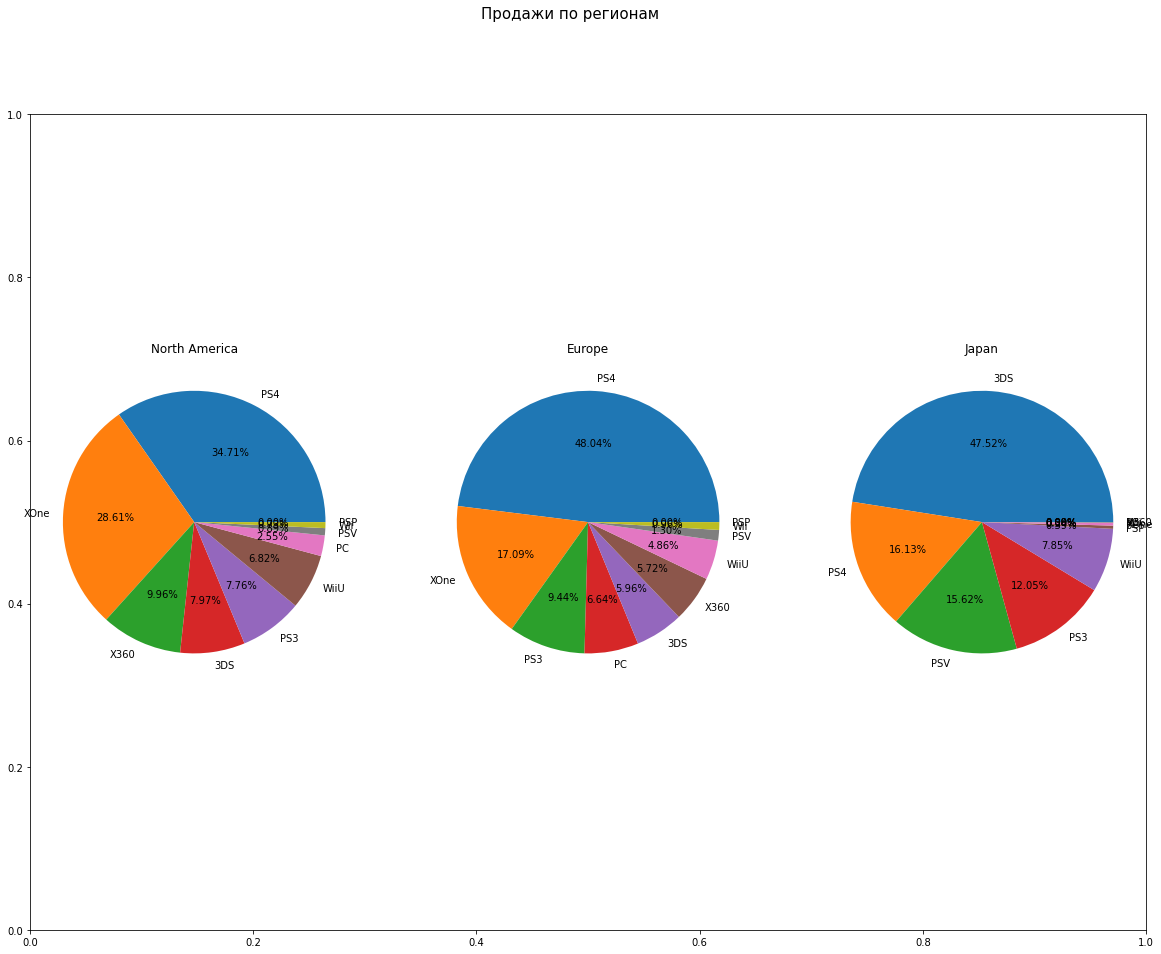

In [44]:
na_platforms = games_2014.pivot_table(index='platform', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)

eu_platforms = games_2014.pivot_table(index='platform', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values(by='eu_sales', ascending=False)

jp_platforms = games_2014.pivot_table(index='platform', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values(by='jp_sales', ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pie(data=na_platforms, x='na_sales', autopct='%.2f%%', labels = na_platforms['platform'])
ax2.pie(data=eu_platforms, x='eu_sales', autopct='%.2f%%', labels = eu_platforms['platform'])
ax3.pie(data=jp_platforms, x='jp_sales', autopct='%.2f%%', labels = jp_platforms['platform'])
plt.suptitle('Продажи по регионам', fontsize=(15))
ax1.set_title('North America')
ax2.set_title('Europe')
ax3.set_title('Japan')

По графику можно увидеть, что большая часть продаж в Северной Америке и Европе принадлежит PS4, в Северной Америке ее доля составляет почти 35%, а в Европе 48%. Второе место в Северной Америке и Европе занимает XOne (28,6% и 17%). В Японии с большим отрывом лидирует платформа 3DS, ее продажи примерно равны 48% от общего кол-ва, далее идут PS4, PSV, PS3, но их кол-во не достигает и 20%.

In [45]:
na_genre = games_2014.pivot_table(index='genre', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)
na_genre 

,genre,na_sales
8,Shooter,79.02
0,Action,72.53
10,Sports,46.13
7,Role-Playing,33.47
3,Misc,15.05
2,Fighting,12.43
6,Racing,8.74
4,Platform,6.79
1,Adventure,5.64
9,Simulation,2.63


In [46]:
eu_genre = games_2014.pivot_table(index='genre', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values(by='eu_sales', ascending=False)
eu_genre

,genre,eu_sales
0,Action,74.68
8,Shooter,65.52
10,Sports,45.73
7,Role-Playing,28.17
6,Racing,14.13
3,Misc,12.86
9,Simulation,7.30
4,Platform,6.80
2,Fighting,6.69
1,Adventure,6.49


In [47]:
jp_genre = games_2014.pivot_table(index='genre', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values(by='jp_sales', ascending=False)
jp_genre 

,genre,jp_sales
7,Role-Playing,31.16
0,Action,29.58
2,Fighting,6.37
3,Misc,5.61
8,Shooter,4.87
1,Adventure,3.60
10,Sports,3.26
4,Platform,2.69
9,Simulation,2.31
6,Racing,1.76


Text(0.5, 1.0, 'Japan')

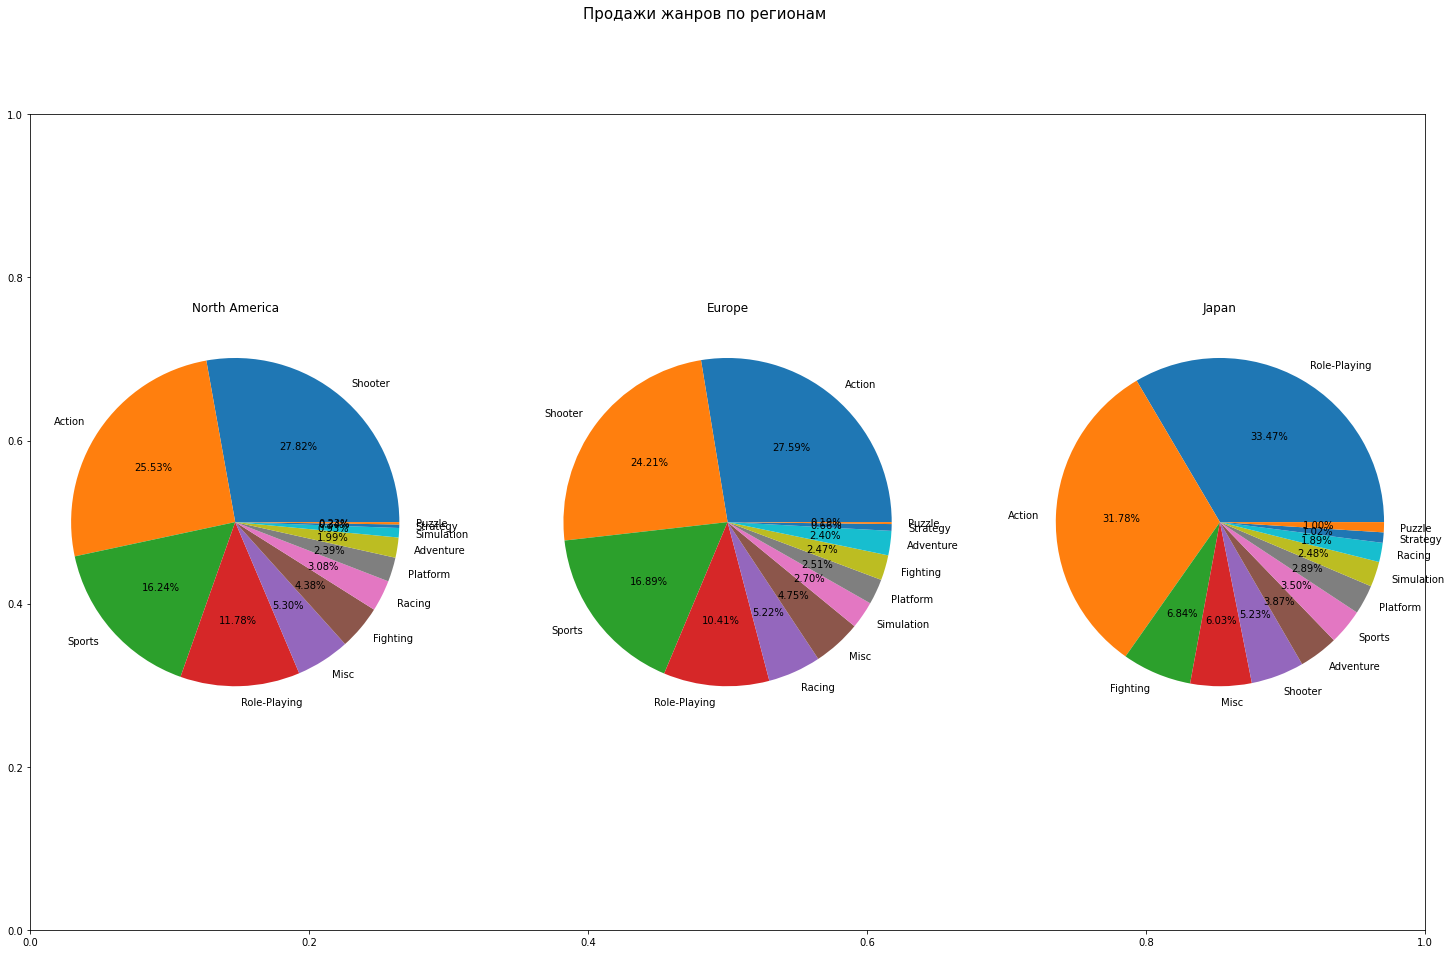

In [48]:
na_genre = games_2014.pivot_table(index='genre', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)
eu_genre = games_2014.pivot_table(index='genre', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values(by='eu_sales', ascending=False)
jp_genre = games_2014.pivot_table(index='genre', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values(by='jp_sales', ascending=False)


fig, ax = plt.subplots(figsize=(25,15))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pie(data=na_genre, x='na_sales', autopct='%.2f%%', labels = na_genre['genre'])
ax2.pie(data=eu_genre, x='eu_sales', autopct='%.2f%%', labels = eu_genre['genre'])
ax3.pie(data=jp_genre, x='jp_sales', autopct='%.2f%%', labels = jp_genre['genre'])
plt.suptitle('Продажи жанров по регионам', fontsize=(15))
ax1.set_title('North America')
ax2.set_title('Europe')
ax3.set_title('Japan')

В США и Европе самыми популярными жанрами являются Shooter и Action (в сумме примерно 50% от общего количества), далее идут жанры Sports и Role-Playing, продажи по жанрам распределены примерно одинаково. А в Японии Role-Playing являются самым востребованным жанром, далее идет Action, в сумме они занимают больше 60% продаж.

In [49]:
games_2014 = games_2014.fillna(-1)
games_2014['rating'].unique()

array([-1, 'M', 'E', 'T', 'E10+'], dtype=object)

In [50]:
games_2014.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
-1,58.95,56.90,64.72
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95


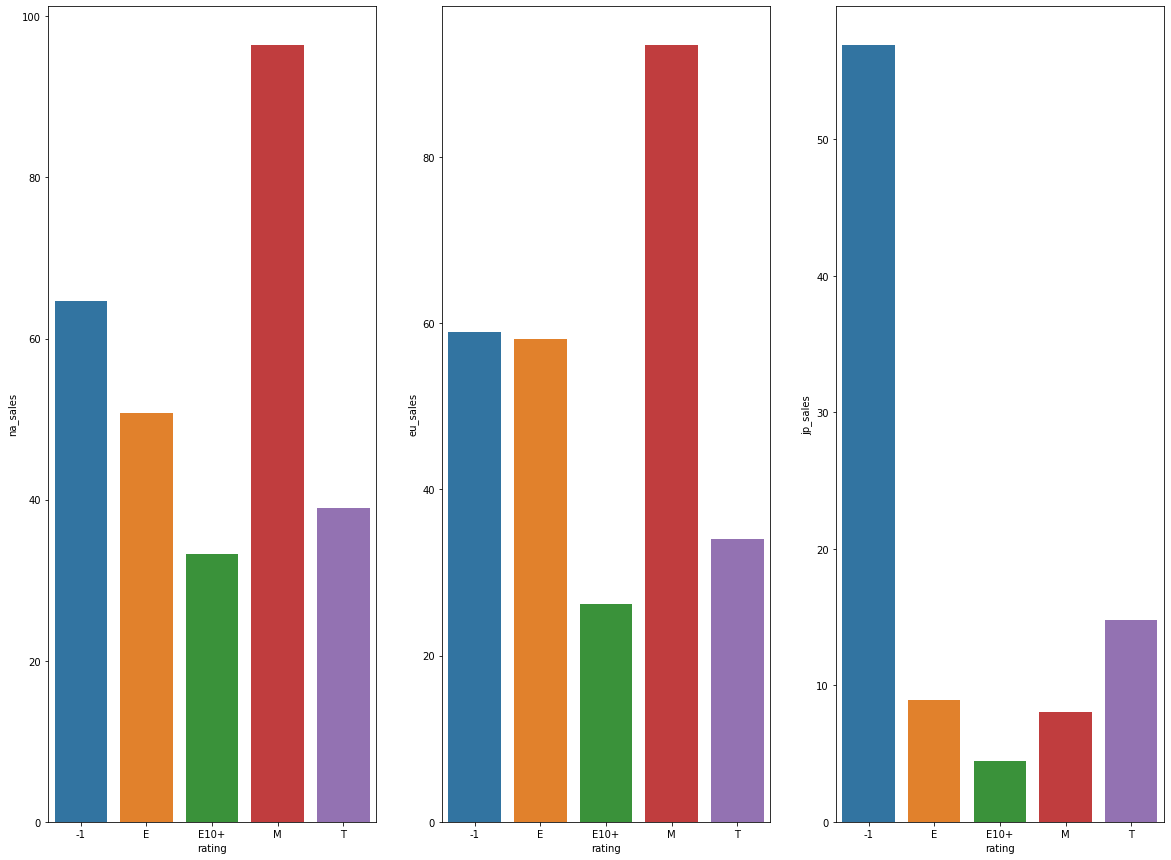

In [51]:
games_raiting = games_2014.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
fig, axes = plt.subplots(1,3, figsize=(20,15))
sns.barplot(x=games_raiting.index, y=games_raiting['na_sales'], ax=axes[0])
sns.barplot(x=games_raiting.index, y=games_raiting['eu_sales'], ax=axes[1])
sns.barplot(x=games_raiting.index, y=games_raiting['jp_sales'], ax=axes[2])
plt.show()

Несмотря на то, что рейтинг ESRB используется в первую очередь в США и Канаде, данные по этому рейтингу присутствует и для других регионов, то есть и для Европы и Японии, данных по Японии крайне мало, что означает, что продажа там игр с таким рейтингом является чем-то исключительным, это доказывает и график, мы использовали заглушку -1 для игр, у оторых отсутсвуют данные по рейтинг ESRB, в Японии таких игр большинство, а вот по кол-ву продаж игр с рейтингом ESRB Европа не сильно устпает Северной Америке.

При исключении из анализа пропусков в столбце рейтинга, в принципе, результат не особо изменился. 

Так, в Северной Америке продажи с большим отрывом  лидируют по играм с рейтингом M, далее идут игры с рейтингом E, в Европе ситуация аналогичная. А вот в Японии по рейтингу лидируют игры с рейтингом T, на втором месте с рейтингом E.

## Проверка гипотез

Первая гипотеза

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

H1: Средние пользовательские рейтинги платформ Xbox One и PC различаются 

Вторая гипотеза

H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые;

H1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различаются

In [53]:
#Первая гипотеза
xone_user_score = games_2014[games_2014['platform'] == 'XOne']['user_score'].dropna()
pc_user_score = games_2014[games_2014['platform'] == 'PC']['user_score'].dropna()

alpha = .05

results = st.ttest_ind(
    xone_user_score,
    pc_user_score,
    equal_var=False)
print('P-value', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')

P-value 0.26246009492976585
Не получилось отвергнуть нулевую гипотезу


In [54]:
#Вторая гипотеза
action_user_score = games_2014[games_2014['genre'] == 'Action']['user_score'].dropna()
sports_user_score = games_2014[games_2014['genre'] == 'Sports']['user_score'].dropna()

alpha = .05

results_1 = st.ttest_ind(
    action_user_score,
    sports_user_score,
    equal_var=False)
print('P-value', results_1.pvalue)
if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')

P-value 4.829372599882802e-05
Отвергаем нулевую гипотезу


Для проверки гипотезы использовался метод о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.
Производилось сравнение критического уровеня статистической значимости и получившимся p-value

In [55]:
results_platforms = games_2014.dropna(subset=['user_score']).pivot_table(index='platform', values='user_score', aggfunc='mean')
results_platforms

,user_score
platform,
3DS,1.111321
PC,4.896689
PS3,2.138813
PS4,4.038298
PSP,-1.000000
PSV,1.142034
Wii,0.336364
WiiU,4.317808
X360,4.063063


In [56]:
results_genre = games_2014.dropna(subset=['user_score']).pivot_table(index='genre', values='user_score', aggfunc='mean')
results_genre

,user_score
genre,
Action,2.723586
Adventure,1.151892
Fighting,3.923333
Misc,1.891150
Platform,4.907895
Puzzle,1.564286
Racing,4.415942
Role-Playing,2.966516
Shooter,5.369531


# Вывод

В ходе исследования было выявлено, что продажи некоторых платформ очень падали с течением времени, а к концу исследуемого периода продажи всех платформ заметно упали. Так, в начале взятого актуального периода, то есть с 2014 года, лидировал PS4  и продажи были примерно 80 млн копий, а к 2016 году они упали  примерно на 10 млн копий. Также было замечено,что продажи PSP крайне малы, что говорит об упадке популярности этой платформы.

Медианной значение у платформ PS4, XOne, WiiU, X360, Wii примерно равно 200 тысячам копий, для остальных оно находится примерно на уровне 100 тыс копий. Верхний предел продаж наивысший у PS4 и Wii.

Была выявлена слабая корреляция между показателями оценки критиков и пользователей и кол-ом продаж. Конечно, чем выше оценка, тем выше продажи, но в то же время достаточное кол-во игр с высоким рейтингом имеют и продажи приближающиеся к 0. 

Большая часть продаж в Северной Америке и Европе принадлежит PS4, в Северной Америке ее доля составляет почти 35%, а в Европе 48%. Второе место в Северной Америке и Европе занимает XOne (28,6% и 17%). В Японии с большим отрывом лидирует платформа 3DS, ее продажи примерно равны 48% от общего кол-ва, далее идут PS4, PSV, PS3, но их кол-во не достигает и 20%.

В США и Европе самыми популярными жанрами являются Shooter и Action (в сумме примерно 50% от общего количества), далее идут жанры Sports и Role-Playing, продажи по жанрам распределены примерно одинаково. А в Японии Role-Playing являются самым востребованным жанром, далее идет Action, в сумме они занимают больше 60% продаж.

В Северной Америке продажи лидируют по играм с рейтингом M и E, в Европе ситуация аналогичная. Но даже для Северной Америке достаточно большое кол-во игр не имеет данных по рейтингу ESRB. Для Японии большая часть игр не имеет даннхы по рейтпнгу ESRB, из-за того, что данный рейтинг применяется в США и Канаде,но из тех игр, для которых данные имеются,лидируют игры с рейтингом T, на втором месте с рейтингом E.

Были исследованы гипотезы: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" и "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"

Первая гипотеза не получилось отвергнуть на уровне значимости 0.05, так как p-value для исследуемых данных было больше, чем критическое значение, то есть средние пользовательские рейтинги Xbox One и PC все-таки одинаковые. Если посмотреть на сводные таблицы, то нельзя сказать, что средние пользовательсике оценки идентичны для Xbox One и PC, тем не менее они расположены достаточно близко друг к другу. А вторая гипотеза наоборот была отвергнута на уровне значимости 0.05, средние пользовательские оценки для жанров Action и Sports различны, что доказывает и сводная таблица.